In [1]:
# fetch dataset

!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2023-09-29 16:45:27--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 188.114.96.8, 188.114.97.8
Connecting to yann.lecun.com (yann.lecun.com)|188.114.96.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9,5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz.3’

train-images-idx3-u 100%[===================>]   9,45M  31,1MB/s    in 0,3s    

2023-09-29 16:45:28 (31,1 MB/s) - ‘train-images-idx3-ubyte.gz.3’ saved [9912422/9912422]

--2023-09-29 16:45:28--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 188.114.97.8, 188.114.96.8
Connecting to yann.lecun.com (yann.lecun.com)|188.114.97.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz.3’

train-labels-idx1-u 100%[===================>]  28,20K  --.-KB/s    in 0,001s  

2023-09-29 16:4

In [2]:
import os
import gzip
import numpy as np

def parse_mnist():
  parse = lambda file: np.frombuffer(gzip.open(file).read(), dtype=np.uint8).copy()
  X_train = parse("train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28)).astype(np.float32)
  y_train = parse("train-labels-idx1-ubyte.gz")[8:]
  X_test = parse("t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28)).astype(np.float32)
  y_test = parse("t10k-labels-idx1-ubyte.gz")[8:]
  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = parse_mnist()

In [3]:
np.random.seed(420)

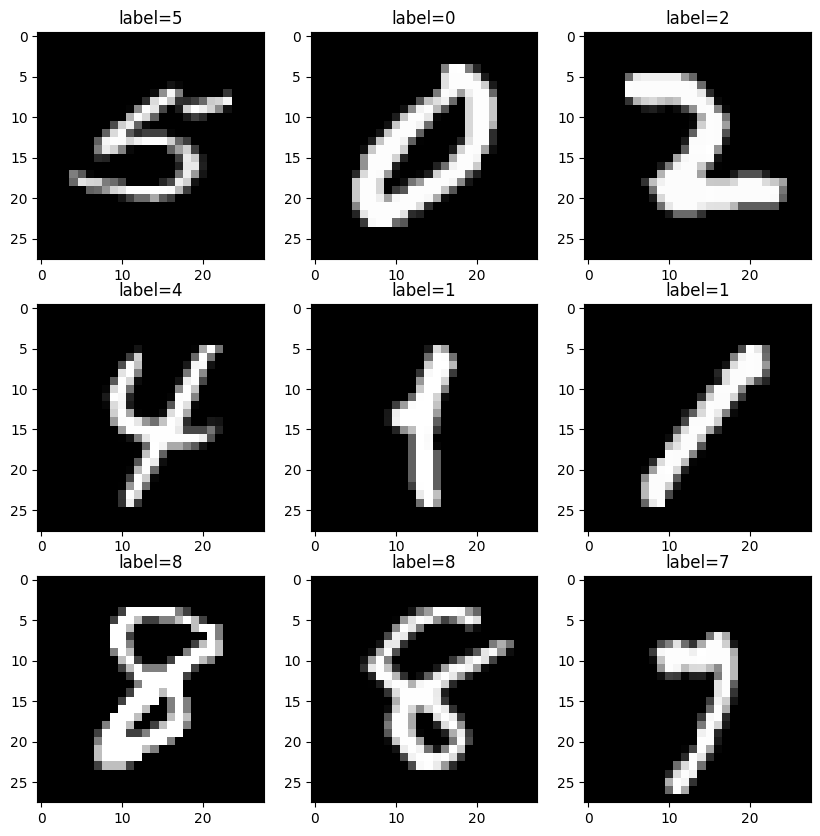

In [4]:
import math
import matplotlib.pyplot as plt

def show_images(images, labels):
  rows = cols = 3 
  
  plt.figure(figsize=(10, 10))
  idx = 1

  for sample in zip(images, labels):
    image = sample[0]
    label = sample[1]

    plt.subplot(rows, cols, idx)
    plt.imshow(image.reshape(28, 28), cmap=plt.cm.gray)

    plt.title(f"label={label}")
    idx+=1

image_idx = np.random.choice(len(X_train), 9, replace=False)
show_images(X_train[image_idx], y_train[image_idx])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


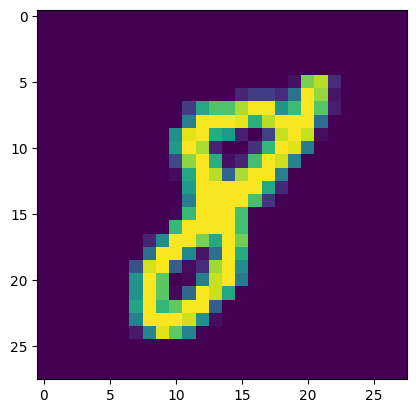

In [5]:
# one hot encode labels
num_classes = 10
onehot = lambda x: np.eye(num_classes)[x.astype(np.int64)]
y_train = onehot(y_train)
y_test = onehot(y_test)

# validate it's accurate
print(y_train[17])
plt.imshow(X_train[17].reshape(28, 28))

In [6]:
def weight_init(input_dim, output_dim):
  return np.random.uniform(-1./math.sqrt(input_dim), 1./math.sqrt(input_dim), size=(input_dim, output_dim))

# takes the predicted probability distribution (after applying softmax) and the onehot encoded true label
def categorical_cross_entropy(probs, y_true):
  eps = 1e-10
  probs = np.clip(probs, eps, 1. - eps)
  return np.mean(-np.sum(y_true * np.log(probs), axis=1)).astype(np.float32)

def softmax(x):
  # Subtract max value for numerical stability
  max_x = np.max(x, axis=1, keepdims=True)
  x_stable = x - max_x
  
  exp_x = np.exp(x_stable)
  sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
  
  probs = exp_x / sum_exp_x
  return probs

def relu(z):
  return np.maximum(0, z)

def relu_grad(a):
  return np.greater(a, 0).astype(np.float32)

In [7]:
class Net():
  def __init__(self):
    self.W1 = weight_init(28 * 28, 512)
    self.b1 = np.zeros(512, dtype=np.float32)
    self.W2 = weight_init(512, 256)
    self.b2 = np.zeros(256, dtype=np.float32)
    self.W3 = weight_init(256, 10)
    self.b3 = np.zeros(10, dtype=np.float32)

  def forward(self, X):
    return self._forward(X)[-1]

  # returns intermediate results for training backprop
  def _forward(self, X):
    s1 = X @ self.W1     # 1
    z1 = s1 + self.b1    # 2
    a1 = relu(z1)        # 3
    s2 = a1 @ self.W2    # 4
    z2 = s2 + self.b2    # 5
    a2 = relu(z2)        # 6
    s3 = a2 @ self.W3    # 7
    z3 = s3 + self.b3    # 8
    y = softmax(z3)      # 9
    return s1, z1, a1, s2, z2, a2, s3, z3, y

# Computation graph to better visualize for backprop

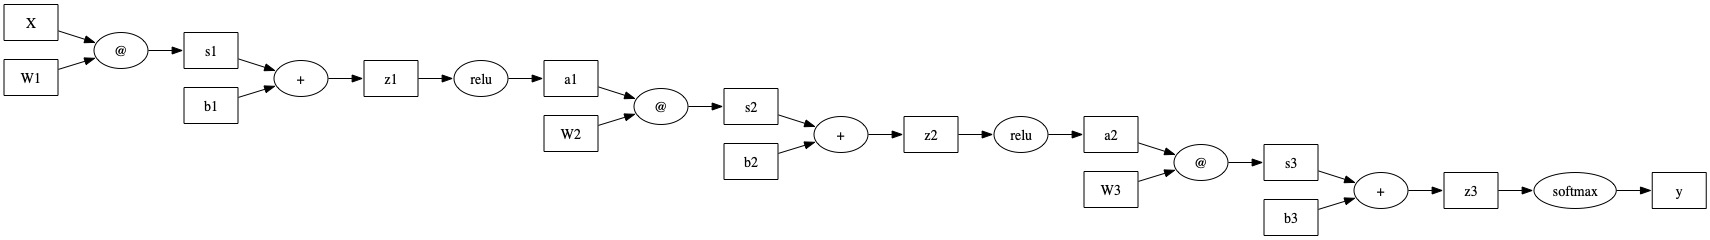

In [8]:
from tqdm.notebook import trange

def train(model: Net, X, y, X_valid, y_valid, epochs=50, batch_size=64, lr=1e-4, weight_decay=1e-5):
  sample_count = len(X)

  train_accuracies = []
  train_losses = [] 
  valid_accuracies = []
  valid_losses = []
  
  for epoch in (t := trange(epochs, dynamic_ncols=True)):
    t.set_description(f'Epoch: {epoch + 1} / {epochs}')
    perm = np.random.permutation(sample_count)
    X_shuffled = X[perm]
    y_shuffled = y[perm]

    train_loss, train_accuracy = _train(model, epoch, X_shuffled, y_shuffled, batch_size, lr, weight_decay)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    valid_loss, valid_accuracy = _validate(model, X_valid, y_valid)
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)

    t.write(f"Epoch: {epoch + 1}/{epochs} Train Loss {train_loss:.4f} Train Accuracy {train_accuracy:.2f} Validation Loss {valid_loss:.4f} Validation Accuracy {valid_accuracy:.2f}")
    
  epochs_range = np.arange(0, epochs)
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_losses, '-o', label='Training Loss')
  plt.plot(epochs_range, valid_losses, '-o', label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Losses')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_accuracies, '-o', label='Training Accuracy')
  plt.plot(epochs_range, valid_accuracies, '-o', label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()
  plt.title('Accuracies')

def _train(model, epoch, X, y, batch_size, lr, weight_decay):
  sample_count = len(X)
  batch_count = sample_count / batch_size

  total_loss = 0.
  total_accuracy = 0.
  
  for i in range(0, sample_count, batch_size):
    X_batch = X[i:i+batch_size]
    y_batch = y[i:i+batch_size]

    # forward
    s1, z1, a1, s2, z2, a2, s3, z3, y_pred = model._forward(X_batch)
    
    loss = categorical_cross_entropy(y_pred, y_batch)
    total_loss += loss

    accuracy = (y_batch.argmax(axis=1) == y_pred.argmax(axis=1)).mean() * 100
    total_accuracy += accuracy
    
    # backprop
    dLdz3 = y_pred - y_batch  # CCE + softmax grad

    dLds3 = dLdz3 * 1.0  # 8
    dLdb3 = dLdz3 * 1.0  # 8

    dLda2 = dLds3 @ model.W3.T # 7
    dLdW3 = a2.T @ dLds3       # 7

    dLdz2 = dLda2 * relu_grad(a2) # 6
    
    dLds2 = dLdz2 * 1.0  # 5 
    dLdb2 = dLdz2 * 1.0  # 5 
  
    dLda1 = dLds2 @ model.W2.T # 4
    dLdW2 = a1.T @ dLds2 # 4
  
    dLdz1 = dLda1 * relu_grad(a1) # 3
    
    dLds1 = dLda1 * 1.0 # 2
    dLdb1 = dLda1 * 1.0 # 2
    
    dLdW1 = X_batch.T @ dLds1 # 1
  
    # SGD update
    model.W1 = model.W1 - (lr / batch_size) * dLdW1 - (lr * weight_decay * model.W1)
    model.W2 = model.W2 - (lr / batch_size) * dLdW2 - (lr * weight_decay * model.W2)
    model.W3 = model.W3 - (lr / batch_size) * dLdW3 - (lr * weight_decay * model.W3)
    model.b1 = model.b1 - lr * np.mean(dLdb1, axis=0)
    model.b2 = model.b2 - lr * np.mean(dLdb2, axis=0)
    model.b3 = model.b3 - lr * np.mean(dLdb3, axis=0)

  return total_loss / batch_count, total_accuracy / batch_count

def _validate(model, X, y):
  y_pred = model.forward(X)
  
  loss = categorical_cross_entropy(y_pred, y)
  accuracy = (y.argmax(axis=1) == y_pred.argmax(axis=1)).mean() * 100

  return loss, accuracy

In [9]:
epochs = 15
batch_size = 64
lr = 1e-3
weight_decay = 1e-5

  0%|                                                                                                         …

Epoch: 1/15 Train Loss 0.4364 Train Accuracy 88.99 Validation Loss 0.1718 Validation Accuracy 94.80
Epoch: 2/15 Train Loss 0.1686 Train Accuracy 94.94 Validation Loss 0.1359 Validation Accuracy 96.10
Epoch: 3/15 Train Loss 0.1204 Train Accuracy 96.38 Validation Loss 0.1298 Validation Accuracy 96.02
Epoch: 4/15 Train Loss 0.0946 Train Accuracy 97.19 Validation Loss 0.1188 Validation Accuracy 96.68
Epoch: 5/15 Train Loss 0.0773 Train Accuracy 97.74 Validation Loss 0.1102 Validation Accuracy 96.85
Epoch: 6/15 Train Loss 0.0642 Train Accuracy 98.12 Validation Loss 0.1029 Validation Accuracy 97.10
Epoch: 7/15 Train Loss 0.0541 Train Accuracy 98.48 Validation Loss 0.1001 Validation Accuracy 97.05
Epoch: 8/15 Train Loss 0.0464 Train Accuracy 98.75 Validation Loss 0.0967 Validation Accuracy 97.48
Epoch: 9/15 Train Loss 0.0396 Train Accuracy 98.97 Validation Loss 0.0978 Validation Accuracy 97.52
Epoch: 10/15 Train Loss 0.0340 Train Accuracy 99.18 Validation Loss 0.0953 Validation Accuracy 97.43

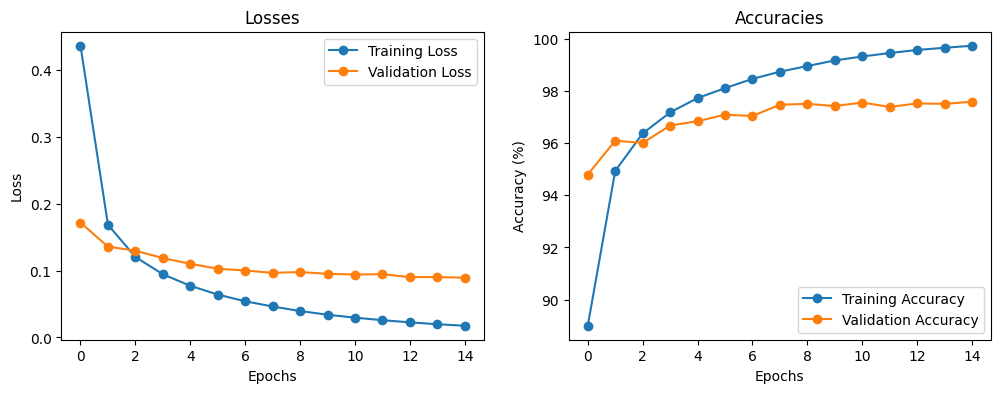

In [10]:
model = Net()

n = int(0.9 * len(X_train))

X_t, y_t = X_train[:n], y_train[:n]
X_v, y_v = X_train[n:], y_train[n:]

train(model, X_t, y_t, X_v, y_v, epochs=epochs, lr=lr)

In [11]:
y_pred = model.forward(X_test)
(y_test.argmax(axis=1) == y_pred.argmax(axis=1)).mean()

0.9721